# Nichtlineare Systeme und Maschinelles Lernen

In [221]:
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Definiere ein nichtlineares System: Tank mit Zu- und Ablauf

$h(t) = A_{zu} /A \int{u(t) dt} - A_{abfluss}/A \sqrt{2 g} \int{\sqrt{h(t)} dt}$ 

Überführung in eine Zustandsdarstellung

$ \dot{h}(t) = 1/A u(t) - A_{abfluss}/A \sqrt{2 g} \sqrt{h(t)}$

Zeitdiskretisierung 

$ \dot{h}(t) \approx \frac{h(k+1) - h(k) }{T} $

In [222]:
# Anzahl der Zeitschritte für die Simulation des Tanks
n_iter = 10000
T = 0.01
x = np.zeros(n_iter)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
u_white = np.random.normal(0.2, 0.4, n_iter)

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    x[k+1] = Azu/A * T * u [k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen

h_normal = h

Text(0.5, 1.0, 'Tanksystem, Ausgangszustand')

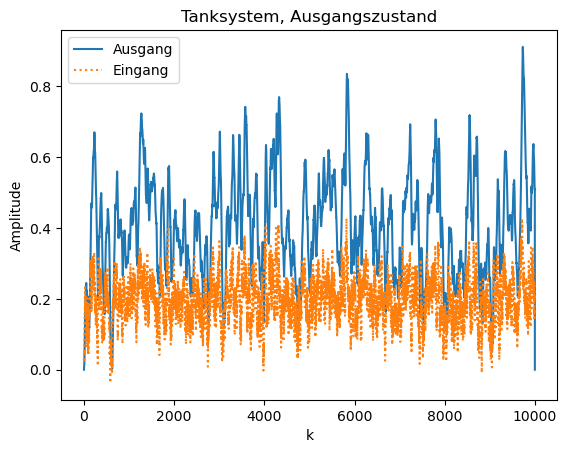

In [223]:
plt.figure()
plt.plot(h_normal, label= 'Ausgang')
plt.plot(u,linestyle=':', label='Eingang')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()
plt.title("Tanksystem, Ausgangszustand")

## Simulation verschiedener Fehler

### Zustände des Tanksystems 
1. Nominalzustand (wie oben simuliert)
2. Zulaufventil hängt fest: unabhängig vom Eingangssignal wird ein fester Wert für den Zulauf gesetzt
4. Ablauf teilweise verstopft: Querschnitt des Ablaufs wird temporär verringert
5. Füllstandssensor mit elektrischem Fehler. 50Hz Signal wird eingestreut: Überlagerung des Ausgangssignals mit einem periodischen Störsignal

Modellierung durch einen Markov-Prozess:

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

Der Markov-Prozess stellt sein System durch verschiedene Zustände dar, die über der Zeit mit definierten Wahrscheinlichkeiten wechseln.

In [224]:
from scipy.stats import multinomial
from typing import List

def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [225]:
# Wahrscheinlichkeitsverteilung des Ausgangszustands
p_init = np.array([1.0, 0.0])
# Wahrscheinlichkeiten für den Zustandsübergang
p_transition = np.array([[0.99, 0.01],[0.01, 0.99]])
# Berechnung einer Markov-Sequenz 
states = markov_sequence(p_init, p_transition, sequence_length=n_iter)

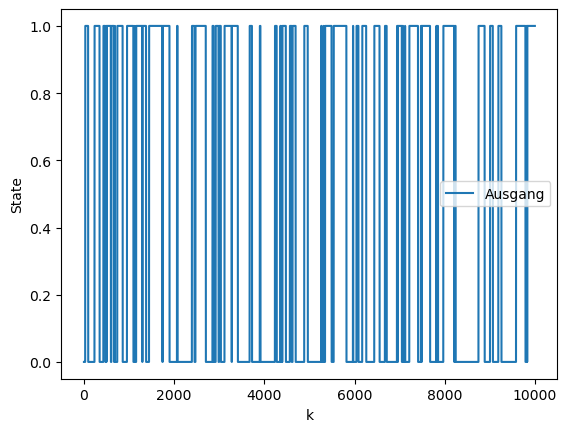

In [226]:
plt.figure()
plt.plot(states, label= 'Ausgang')
#plt.plot(u,linestyle=':', label='Eingang')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()

Modifikation des Tankmodells zur Abbildung von Fehlerzuständen



In [227]:
# Anzahl der Zeitschritte für die Simulation des Tanks
x = np.zeros(n_iter)
u_in = np.zeros_like(x)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
# u_white = np.random.normal(0.2, 0.4, n_iter) kein neues Eingangssignal generieren

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

    if states[k] == 2:
        # Ventilantrieb hängt: Werte bleiben 
        u_in[k] = u_in[k-1] 
    else:
        u_in[k] = u[k]

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    if states[k] == 0:
        Aab = 0.5
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    elif states[k] == 1:
        # Ablauf verstopft -> Ablaufquerschnitt verkleinert
        Aab = 0
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
  
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen


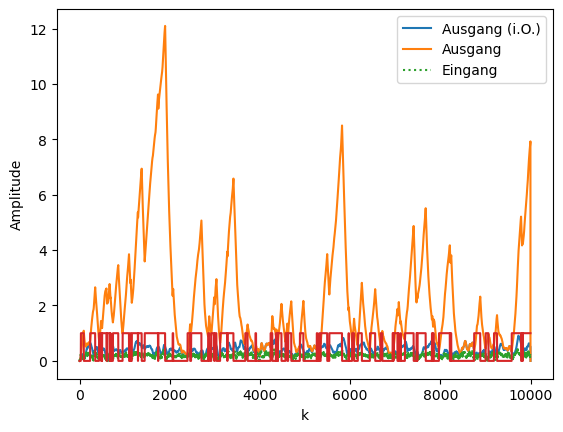

In [228]:
plt.figure()
plt.plot(h_normal, label="Ausgang (i.O.)")
plt.plot(h, label= 'Ausgang')
plt.plot(u, linestyle=':', label='Eingang')
plt.plot(states)
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

## Versuch der Schätzung eines nichtlinearen Modells

In [229]:
import sklearn.svm as skm

Anordnen der Daten 

In [230]:
# Regressor
# Features für das Training: Samples der Zeitreihen von Ein- und Ausgang
# Anzahl der Samples (u und k gleich viele)
l = 10
phi = np.zeros((n_iter, 2*l))
for k in range(n_iter-l):
    phi[k, :] = np.concatenate(([u[k:k+l],h[k:k+l]]), axis=None)

### Erkundung des Raums der Eingangsvektoren 

Für dieses einfache Beispiel gibt es nur 2 Eingänge: Das Steuersignal u(k-1) und die Füllhöhe h(k-1) aus dem letzten Rechenschritt, aus denen die Füllhöhe h(k) bestimmt werden soll. 

Was bewirkt eine Änderung der Länge des Trainingsdatensatzes (n_iter)?

Text(0, 0.5, 'h')

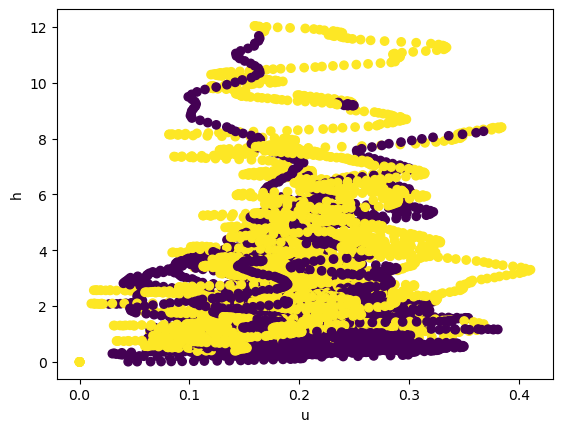

In [231]:
plt.figure()
plt.scatter(np.mean(phi[:,0:l],1), np.mean(phi[:,(l+1):-1],1), c = states)
plt.xlabel('u')
plt.ylabel('h') 

Testen verschiedener Modelle aus Scikit Learn.

GridSearch trainiert verschiedene Modelle im durch param_grid aufgespannten Parameterraum und ermittelt die beste Lösung.  
Die Prozedur kann je nach Größe des Grids und der Länge der Trainingsdaten sehr zeitaufwändig werden!

Interessant ist die Untersuchung, wie sich verschiedene Parametersätze und auch Längen des Trainingsdatensatzes auswirken.


In [232]:
#from sklearn.model_selection import GridSearchCV
#clf_grid = GridSearchCV(skm.SVR(kernel='rbf', gamma="scale"),
#                  param_grid={"C": [1e3, 1e4]})
#clf_grid.fit(phi, states)[[]]
#clf = skm.SVR(kernel='rbf', gamma="scale")
#clf= clf.fit(phi, states)
#clf  = clf_grid.best_estimator_ 



In [233]:
# Testen eines Decision Tree classifiers
#from sklearn import tree
#clf = tree.DecisionTreeClassifier()
clf = tree.DecisionTreeRegressor(max_depth=8)
clf= clf.fit(phi, states)

In [234]:
# Prädiktion mit den Ausgangswerten aus den Trainingsdaten, die im Regressor gesammelt wurden
h_predict = clf.predict(phi)

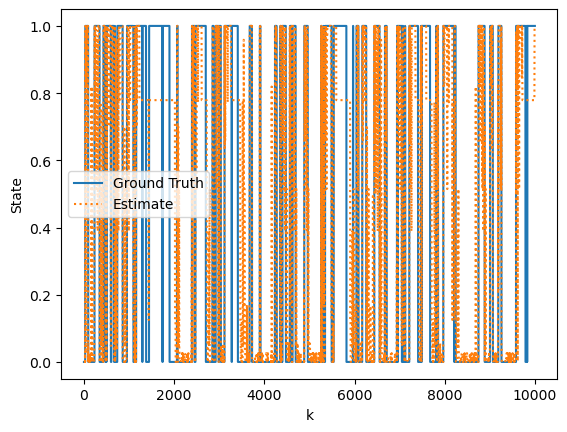

In [235]:
plt.figure()
plt.plot(states, label= 'Ground Truth')
plt.plot(h_predict,linestyle=':', label='Estimate')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()

### Testen des trainierten Modells mit einem neuem Datensatz 

In [236]:
n_iter = 1000

In [237]:
# Wahrscheinlichkeitsverteilung des Ausgangszustands
p_init = np.array([1.0, 0.0])
# Wahrscheinlichkeiten für den Zustandsübergang
p_transition = np.array([[0.99, 0.01],[0.01, 0.99]])
# Berechnung einer Markov-Sequenz 
states = markov_sequence(p_init, p_transition, sequence_length=n_iter)

In [238]:
# Anzahl der Zeitschritte für die Simulation des Tanks
x = np.zeros(n_iter)
u_in = np.zeros_like(x)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
#u_white = np.random.normal(0.2, 0.4, n_iter)

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

    if states[k] == 2:
        u_in[k] = u_in[k-1]
    else:    
        u_in[k] = u[k]
        # Ventilantrieb hängt: Werte bleiben 
         

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    if states[k] == 0:
        Aab = 0.5
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    elif states[k] == 1:
        # Ablauf verstopft
        Aab = 0.01
        x[k+1] = Azu/A * T * u_in[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
  
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen


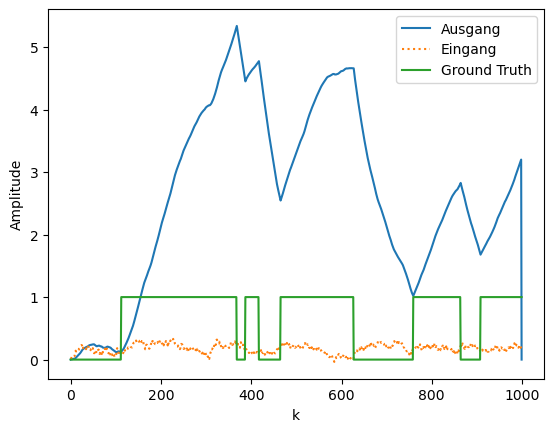

In [239]:
plt.figure()
plt.plot(h, label= 'Ausgang')
plt.plot(u, linestyle=':', label='Eingang')
plt.plot(states, label= 'Ground Truth')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

In [240]:
# Regressor
phi = np.zeros((n_iter, l*2))
for k in range(n_iter-l):
    phi[k,:] = np.concatenate(([u[k:k+l],h[k:k+l]]), axis=None)

In [241]:
# Prädiktion mit den Ausgangswerten aus den Trainingsdaten, die im Regressor gesammelt wurden
h_predict = clf.predict(phi)

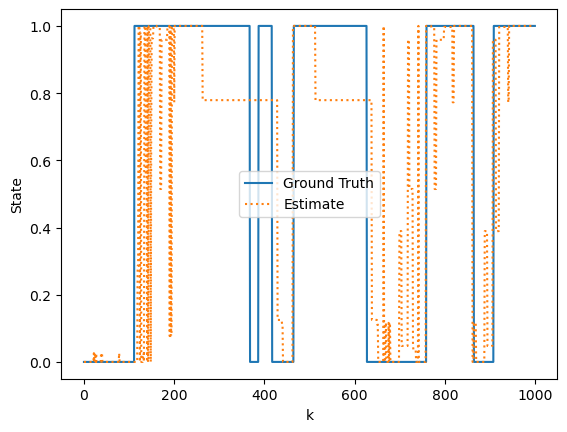

In [242]:
plt.figure()
plt.plot(states, label= 'Ground Truth')
plt.plot(h_predict,linestyle=':', label='Estimate')
plt.xlabel('k')
plt.ylabel('State')
plt.legend()